#PyTorch - wiadomości teoretyczne wstępne.

Do optymalizacji parametrów (wag) sieci neuronowej podczas treningu modelu wykorzystuje się **metodę stochastycznego spadku wzdłuż gradientu**.
Gradient funkcji straty względem parametrów sieci wyznaczany jest algorytmem **propagacji wstecznej** (*back propagation*).

Sieć neuronowa jest niczym innym jak złożoną funkcją mapującą wejściowe dane $x \in \mathcal{X}$ (np. obraz czy sekwencjęaudio) na wyjście $y \in \mathcal{Y}$, parametryzowaną zestawem paarametrów (wag) $\theta$.
$$
f_{\theta}( x ) = y
$$
W przypadku $n$-klasowego klasyfikatora wyjściem z sieci jest wektor $y \in \mathbb{R}^n$ nieznormalizowanych wartości, zwanych logitami. Z nich możemy wyznaczyć rozkład prawdopodobieństwa klas korzystając z funkcji softmax.

W jednym kroku treningu sieci neuronowych wykonujemy:
1. **Przejście w przód** - przetworzenie zestawu wejściowych danych treningowych przez sieć i wyznaczenie wartości wynikowych $y = f_{\theta}(x)$. Następnie wyznaczenie wartości funkcji straty
$\mathcal{L}$
w oparciu o wynikową wartość z sieci i prawdziwą (docelową) wartość.
2. **Przejście w tył** (propagacja wsteczna) - wyznaczenie **gradientu funkcji  straty** $\mathcal{L}$ **względem parametrów sieci** $\theta$.
3. **Krok optymalizacji parametrów sieci** - zmiana w kierunku przeciwnym do gradientu.



##Przygotowanie środowiska
Upewnij się, że notatnik jest uruchomiony na maszynie z GPU. Jeśli GPU nie jest dostępne zmień typ maszyny (Runtime | Change runtime type) i wybierz T4 GPU.

In [1]:
!nvidia-smi

Tue Mar  4 19:30:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Bibliotek PyTorch jest domyślnie zainstalowana w środowisku COLAB.

In [2]:
import torch # PyTorch
import numpy as np

print(f"Wersja biblioteki PyTorch {torch.__version__}")

Wersja biblioteki PyTorch 2.5.1+cu124


Sprawdzenie dostępnego urządzenia GPU:

In [3]:
print(f"Dostępność GPU: {torch.cuda.is_available()}")
print(f"Typ GPU: {torch.cuda.get_device_name(0)}")

Dostępność GPU: True
Typ GPU: Tesla T4


Instalacja pakietu torchviz do wizualizacji grafów obliczeń ([link](https://github.com/szagoruyko/pytorchviz)).

In [4]:
!pip install -q torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.0 MB/s eta 0:00:00


#Automatyczne różniczkowanie (`torch.autograd`)

**Gradient** (lub gradientowe pole wektorowe) funkcji skalarnej wielu zmiennych $
f: \mathbb{R}^D → \mathbb{R}
$ oznaczamy
$\nabla f$ (czytaj: nabla).
W układzie współrzędnych kartezjańskich gradient jest wektorem, którego składowe są pochodnymi cząstkowymi funkcji $f$:
$$\nabla f=\left[{\frac {\partial f}{\partial x_{1}}},\dots ,{\frac {\partial f}{\partial x_{n}}}\right]$$

Niech $\mathcal{L}: \mathbb{R}^D \rightarrow \mathbb{R}$ będzie pewną funkcją straty określoną dla sieci neuronowej o $D$ parametrach (wagach).
Celem treningu sieci neuronowej jest znalezienie zestawu parametrów $\mathbf{\hat{w}} \in \mathbb{R}^D$ minimalizującego wartość funkcji straty:
$$\mathbf{\hat{w}} = \arg \min_{\textbf{w}} \mathcal{L} \left( \textbf{w} \right)$$
W metodzie **spadku wzdłuż gradientu** zaczynamy od losowo zainicjalizowanych parametrów (wag) sieci $\textbf{w}_0$ a następnie iteracyjnie aktualizujemy parametry sieci w kierunku przeciwnym do wartości gradientu:
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta \nabla \mathcal{L} \left( \mathbf{w}_t \right)
$$





Aby wyznaczyć **gradient funkcji straty względem parametrów sieci**, PyTorch posiada wbudowany mechanizm różniczkowania o nazwie `torch.autograd`. Umożliwia on automatyczne obliczanie gradientu dla dowolnego grafu obliczeniowego.

Obiekty typu Tensor posiadają logiczną flagę `requires_grad`.
Domyślnie flaga `requires_grad` jest ustawiana na `False`.
Po jej włączeniu PyTorch będzie automatycznie budował grafy dla wszystkich obliczeń wykonanych z wykorzystaniem tego tensora aby umożliwić automatyczne wyznaczanie gradientu.
Jeśli jeden z argumentów operacji na tensorach ma ustawioną flagę `requires_grad`, wynik również będzie miał ustawioną tę flagę.

In [5]:
x = torch.tensor([ 1., 2. ])
y = torch.tensor([ 4., 5. ])
z = torch.tensor([ 7., 3. ])
print(f"{x.requires_grad=}")
print(f"{y.requires_grad=}")
print(f"{(x + y).requires_grad=}\n")

x.requires_grad = True
print(f"{x.requires_grad=}")
print(f"{y.requires_grad=}")
print(f"{(x + y).requires_grad=}")

x.requires_grad=False
y.requires_grad=False
(x + y).requires_grad=False

x.requires_grad=True
y.requires_grad=False
(x + y).requires_grad=True


###Przykład 1
Rozważmy funkcję:
$$
f(t, u) = \sum_i t_i^2 + \sum_j \log u_j \, ,
$$
gdzie $t \in \mathbb{R}^n, u \in \mathbb{R}^m$.

Zaimplementujmy wyznaczenie wartości tej funkcji w PyTorch dla przykładowych parametrów $t=[1,2,4]$ i $u=[10,20]$. Aby było możliwe wyznaczenie wartości gradientu $f$ dla tych parametrów włączymy flagę `requires_grad`.

In [6]:
t = torch.tensor([1., 2., 4.])
t.requires_grad = True

u = torch.tensor([10., 20.])
u.requires_grad = True

f = t.pow(2).sum() + u.log().sum()

print(f"{f = }")
print(f"{f.requires_grad = }")

f = tensor(26.2983, grad_fn=<AddBackward0>)
f.requires_grad = True


Wizualizacja grafu obliczeń dla tensora f.

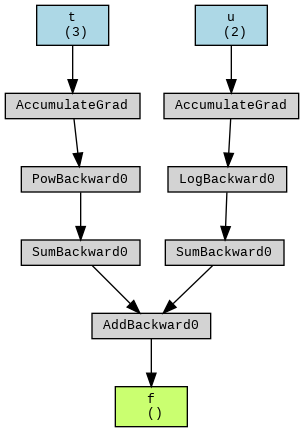

In [7]:
from torchviz import make_dot
from IPython.display import Image, display

dot = make_dot(f, params={"t" : t, "u" : u, "f" : f}) #generowanie wizuulizacji grafu
dot.render("computational_graph", format="png") # metoda render zap[isuje graf do pliku ]
display(Image(filename="computational_graph.png")) # metoda która wyświetla obraz

Metoda `f.backward()` wykonuje przejście w tył przez graf obliczeń w celu wyznaczenia gradientów względem parametrów (tensorów z włączoną flagą `requires_grad`) wykorzystanych do wyznaczenia wartości `f`. W naszym przypadku są to tensory `t` i `u`.

Pochodne cząstkowe funkcji $f$ względem parametrów $t$ i $u$ możemy wyznaczyć analitycznie:
$
\frac{\partial f}{\partial t_i} = 2 t_i
$ i
$
\frac{\partial f}{\partial u_i} = \frac{1}{u_i}
$.
Jak widać wyznaczone analitycznie wartości gradientu są identyczne jak wartości wyznaczone automatyczniez wykorzystaniem grafu obliczeń.


In [8]:
print("\nPrzed wykonaniem f.backward()")
print(f"{t.grad = }")
print(f"{u.grad = }")

f.backward()

print("\nPo wykonaniu f.backward()")
print(f"{t.grad = }")
print(f"{u.grad = }")
#


Przed wykonaniem f.backward()
t.grad = None
u.grad = None

Po wykonaniu f.backward()
t.grad = tensor([2., 4., 8.])
u.grad = tensor([0.1000, 0.0500])


##Przykład 2
Rozważmy najprostszą sieć neuronową złożoną z jednej warstwy liniowej z wejściem `x` $\in \mathbb{R}^{5}$ oraz pewną funkcję straty `loss`.
Warstwa liniowa jest zaimplementowana w PyTorch jako klasa `nn.Linear` ([link](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear)).

Do celów poglądowych zasymulujemy działanie warstwy linowej korzystając z macierzy wag `w` $\in \mathbb{R}^{5 \times 3}$ i wektora obciążenia (*bias*) `b` $\in \mathbb{R}^{3}$.
`w` i `b` są **parametrami**, które chcemy optymalizować w procesie uczenia sieci. W tym celu musimy wyznaczyć gradient funkcji straty względem tych parametrów. Aby umożliwić automatyczne wyznaczanie gradientu dla tych parametrów, ustawiamy dla nich atrybut `requires_grad` na `true`.
Zauważmy, że tensory utworzone w oparciu o choćby jeden tensor z atrybutem `requires_grad`, w tym przypadku `z` i `loss`, również będą miały aktywne wyznaczanie gradientu.

**Uwaga**: Jesli wykorzystujemy moduły sieci dziedziczące z klasy `nn.Module` (np. `nn.Linear`, `nn.Conv2D`) tensory parametrów (wag) mają atrybut `requires_grad` domyślnie ustawiony na `true`.

In [9]:
import torch.nn as nn

x = torch.ones(5)     #tensor wejściowy
y = torch.zeros(3)    #oczekiwane wyjście

#Definiujemy początkowe parametry wartstwy liniowej : macierz wag i wektor obciażenia (bias)
w = torch.randn((5, 3), requires_grad=True)
b = torch.randn(3, requires_grad=True)

z = x @ w + b #mnożenie macierzy

#Wyznaczamy wartość funkcji straty jako funkcję entropii krzyżowej między wyjściem z sieci a oczekiwanym wyjściem

loss = nn.functional.binary_cross_entropy_with_logits(z, y)

In [10]:
print(f"{z = }")
print(f"{z.requires_grad = }")
print(f"{loss = }")
print(f"{loss.requires_grad = }")

z = tensor([-2.0312, -2.2099,  1.4802], grad_fn=<AddBackward0>)
z.requires_grad = True
loss = tensor(0.6375, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss.requires_grad = True


###Wizualizacja grafu obliczeń

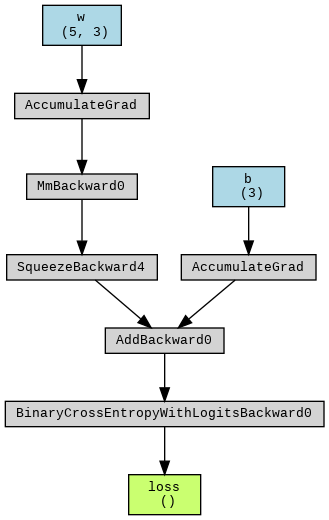

In [11]:
dot = make_dot(loss, params={"w" : w, "b" : b, "loss" : loss})
dot.render("computational_graph_loss", format="png")
display(Image(filename="computational_graph_loss.png"))

In [12]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7cf82af216f0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7cf82af23e50>


###Obliczanie gradientu

Aby wykonać jeden krok optymalizacji wag sieci musimy wyznaczyć gradient funkcji straty względem parametrów sieci, czyli $\frac{\partial loss}{\partial w}$ i
$\frac{\partial loss}{\partial b}$ dla ustalonych wartości `x` i
`y`.
Aby wyznaczyć te pochodne cząstkowe wywołujemy funkcję `loss.backward()`. Wyznaczone pochodne zostaną zapisane w atrybutach `w.grad` and `b.grad`.

In [13]:
print(f"Gradient funkcji względem parametrów w i b:")
loss.backward()
print(f"{w.grad=}")
print(f"{b.grad=}")

Gradient funkcji względem parametrów w i b:
w.grad=tensor([[0.0387, 0.0330, 0.2715],
        [0.0387, 0.0330, 0.2715],
        [0.0387, 0.0330, 0.2715],
        [0.0387, 0.0330, 0.2715],
        [0.0387, 0.0330, 0.2715]])
b.grad=tensor([0.0387, 0.0330, 0.2715])


Zasymulujemy teraz jeden krok optymalizacji parametrów sieci metodą spadku wzdłuż gradientu.
Gradient funkcji straty `loss` względem parametrów (macierz wag `w` i wektor obciążeń `b`) wyznaczony w poprzednim kroku określa kierunek maksymalnego wzrostu wartości funkcji straty.
Ponieważ chcemy minimalizować wartość funkcji straty, musimy zmieniać parametry w kierunku przeciwnym do gradientu.

Graf obliczeń powinien być budowany tylko dla obliczeń prowadzących do wyznaczenia wartości funkcji straty.
Przy samej aktualizacji parametrów sieci z wykorzystaniem wyznaczonych gradientów powinniśmy wyłączyć budowanie grafu obliczeń korzystając z menadżera kontekstu `torch.no_grad():`.


In [14]:
print(f"Początkowa wartość funkcji straty: {loss:.5f}")

learning_rate = .5
with torch.no_grad():
    w -= learning_rate * w.grad
    b -= learning_rate * b.grad

z = x @ w + b
loss2 = nn.functional.binary_cross_entropy_with_logits(z, y)

print(f"Wartość funkcji straty po jednym kroku optymalizacji parametrów: {loss2:.10f}")

Początkowa wartość funkcji straty: 0.63753
Wartość funkcji straty po jednym kroku optymalizacji parametrów: 0.4285127819


**Uwaga:** Ze względów wydajnościowych wyznaczone pochodne są zapisywane tylko dla liści grafu obliczeń z ustawionym atrybutem `requires_grad`. Dla wewnętrznych węzłów w grafie obliczeń (w naszym przypadku `z` i `loss`) atrybut `grad` nie jest zapisywany.

In [15]:
print(f"{z.grad=}")
print(f"{loss.grad=}")

z.grad=None
loss.grad=None


<ipython-input-15-8c375960b611>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(f"{z.grad=}")
<ipython-input-15-8c375960b611>:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for mo

Zapisywanie wartości wyznaczonego gradientu dla wewnętrznych węzłów w grafie obliczeń można włączyć wywołując dla nich metodę `retain_grad()`.

In [16]:
# Parametry warstwy liniowej: macierz wag i wektor obciążenia (bias)
w = torch.randn((5, 3), requires_grad=True)
b = torch.randn(3, requires_grad=True)

z = x @ w + b
z.retain_grad()

# Wyznaczmy wartość funkcji straty jako funkcję entropii krzyżowej między
# wyjściem z sieci a oczekiwanym wyjście
loss = nn.functional.binary_cross_entropy_with_logits(z, y)
loss.retain_grad()

loss.backward()
print(f"{z.grad=}")
print(f"{loss.grad=}")
print(f"{w.grad=}")
print(f"{b.grad=}")

z.grad=tensor([0.1557, 0.3221, 0.0274])
loss.grad=tensor(1.)
w.grad=tensor([[0.1557, 0.3221, 0.0274],
        [0.1557, 0.3221, 0.0274],
        [0.1557, 0.3221, 0.0274],
        [0.1557, 0.3221, 0.0274],
        [0.1557, 0.3221, 0.0274]])
b.grad=tensor([0.1557, 0.3221, 0.0274])


In [17]:
print(f"Początkowa wartość funkcji straty: {loss:.5f}")

learning_rate = 0.5
with torch.no_grad():
    w -= learning_rate * w.grad
    b -= learning_rate * b.grad

z = x @ w + b
loss2 = nn.functional.binary_cross_entropy_with_logits(z, y)

print(f"Wartość funkcji straty po jednym kroku optymalizacji parametrów: {loss2:.10f}")

Początkowa wartość funkcji straty: 1.36751
Wartość funkcji straty po jednym kroku optymalizacji parametrów: 0.9973123670


##Przykład 3

Funkcja
$$\mathcal{L}=\sqrt{sin \left( x \cdot y + z \right) + 4}$$



In [18]:
x = torch.tensor(2.)
x.requires_grad = True
y = torch.tensor(-1.)
y.requires_grad = True
z = torch.tensor(2.)
z.requires_grad = True

L = torch.sqrt(torch.sin(x * y + z) + 4)

print(f"{L=}")
print(f"{L.requires_grad=}")

L=tensor(2., grad_fn=<SqrtBackward0>)
L.requires_grad=True


In [19]:
L.backward()
print(f"{x.grad=}")
print(f"{y.grad=}")
print(f"{z.grad=}")

x.grad=tensor(-0.2500)
y.grad=tensor(0.5000)
z.grad=tensor(0.2500)


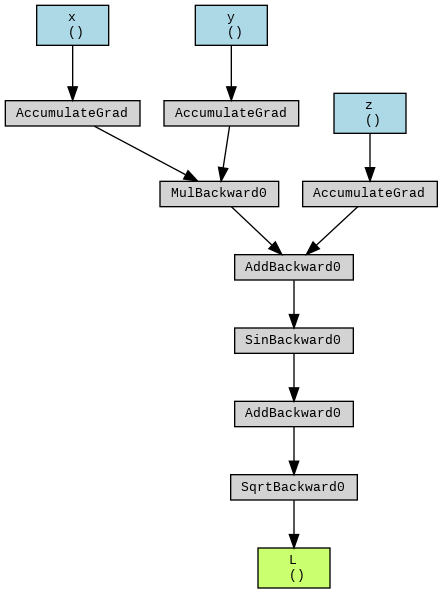

In [20]:
dot = make_dot(L, params={"x": x, "y": y, "z": z, "L": L})
dot.render("computational_graph", format="png")
display(Image(filename="computational_graph.png"))

##Wyłączenie śledzenia historii obliczeń

Historia obliczeń wykonywanych z wykorzystaniem tensorów z atrybutem `requires_grad=True` jest śledzona i automatycznie budowany jest graf obliczeń.  Tensory będące wynkiem takich obliczeń również mają ustawiony atrybut `requires_grad` i historia obliczeń z ich wykonaniem jest dalej śledzona.

W niektórych przypadkach nie jest to konieczne. Jeśli chcemy wykorzystać wcześniej wytrenowany model, i nie zamierzamy optymalizować jego parametrów, możemy wyłączyć śledzenie obliczeń korzystając z menadżera kontekstu `torch.no_grad()`.

Alternatywnie możemy ustawić atrybut `requires_grad` wszystkich lub wybranych parametrów modelu na `False`. W ten sposób można zamrozić część parametrów modelu i optymalizować tylko pozostałe parametry.

In [23]:
x = torch.ones(5)
print(f"{x.requires_grad=}")
print(f"{w.requires_grad=}")
print(f"{b.requires_grad=}")
z = x @ w + b
print(f"{z.requires_grad=}")

with torch.no_grad():
    z = x @ w + b

print(f"{z.requires_grad=}")

x.requires_grad=False
w.requires_grad=True
b.requires_grad=True
z.requires_grad=True
z.requires_grad=False


Aby wyłączyć graf obliczeń od tensora można rónież użyc metodę detach(). Tak stworzony tensor będzie miał pierwotnie wyłączony atrybut requires_grad.

In [25]:
z = x @ w + b
print(f"{z.requires_grad=}")
y = z * 3 + 2
print(f"{y.requires_grad=}")
print()

z_det = z.detach()
print(f"{z_det.requires_grad=}")
y_det = z_det * 3 + 2
print(f"{y_det.requires_grad=}")

z.requires_grad=True
y.requires_grad=True

z_det.requires_grad=False
y_det.requires_grad=False


#Przykład: Regresja logistyczna
Rozważny problem dwuklasowej regresji logistycznej:
$$P(Y=1|X=x) = \sigma(W \cdot x + b) \, ,$$
gdzie $\sigma(x)$ jest **funkcją sigmoidalną** daną wzorem: $$\sigma(x) = \frac{1}{1+\exp(-x)} \, ,$$
a zmienna zależna $Y$ przyjmuje wartości ze zbioru $\left\{ 0, 1 \right\}$.

Funkcja straty binarnej entropii krzyżowej między prawdziwym a estymowanym prawdopodobieństwem dana jest wzorem:
$$
\mathcal{L} = y_i \log \sigma \left(z_i\right) + (1 - y_i) \log
\left( 1 - \sigma \left(z_i\right)  \right) \, ,
$$
gdzie
$$
z_i = W \cdot x_i + b
$$

Problem ten nie ma rozwiązania analitycznego. Wartość parametrów (macierz wag $W$ i wektor obciążenia $b$) możemy znaleźć metodą spadku wzdłuż gradientu.

Korzystając z funkcji make_calssification z biblioteki scikit-learn wygeneruje syntetyczny zzbiór danych.

In [27]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# generowanie zbioru danych
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, n_informative=5, random_state=39)

# Podziele na dane treningowe i testowe

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
print(X_train[:6])
print(y_train[:6])

[[-2.07085312 -0.04064765  0.02678911  0.40361601  0.77851063  1.19922739
  -1.83718679  1.62196421 -1.67020836 -1.12811749]
 [ 1.20151267  1.53972534  0.43779998  0.41853716  1.78489859 -0.10560974
   0.34145075 -1.2861887   1.41252419  1.80916163]
 [ 0.34839753  1.07134756  0.31918828  1.20548051 -0.90091801 -1.48374412
   0.64022087 -0.25634578  1.43057047 -1.00646235]
 [-0.17973526 -0.86915635  0.03128954  0.04013534 -2.30192777 -1.90163566
  -1.3787049  -0.49656222  1.28540426 -0.32678722]
 [ 0.34332545 -2.10856914  1.45879485  0.57750694  0.66091503  1.60508396
   0.43936719  1.16363315 -3.25707337  2.0255843 ]
 [-0.68491842 -1.03644968  2.5674952   0.6762925  -1.81185172 -0.9206438
  -2.81744823  0.66957685 -1.79735995  0.5734468 ]]
[1 0 0 0 0 1]


Wizualizacja dwóch wybranych cech:

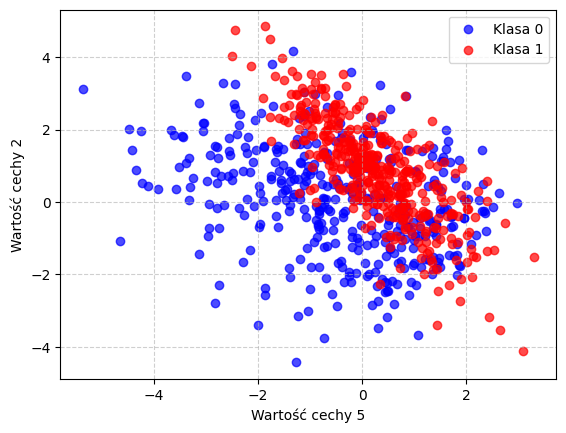

In [29]:
import random
from matplotlib import pyplot as plt

# Wybierz dwie losowe cechy
f1 = random.randint(0, X_train.shape[1]-1)
f2 = random.randint(0, X_train.shape[1]-1)

plt.scatter(X_train[y_train==0, f1], X_train[y_train==0, f2], color='blue', label='Klasa 0', alpha=0.7)
plt.scatter(X_train[y_train==1, f1], X_train[y_train==1, f2], color='red', label='Klasa 1', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel(f"Wartość cechy {f1}")
plt.ylabel(f"Wartość cechy {f2}")
plt.legend()
plt.show()

Możemy zauważyć, że dla dwóch losowo wybranych cech elementy z różnych klas nie są liniowo separowalne.

Utwórzmy warstwe liniową o wymiarze wejścia 10 i wyjścia 1

In [34]:
import torch.nn as nn

print(X_train.shape)
n_features = X_train.shape[1]
linear = nn.Linear(n_features, 1)

print(f"{linear=}\n")
print(f"{linear.weight=}\n")
print(f"{linear.bias=}")

(800, 10)
linear=Linear(in_features=10, out_features=1, bias=True)

linear.weight=Parameter containing:
tensor([[-0.0677,  0.1775,  0.2232,  0.2574, -0.1299, -0.1453,  0.2555, -0.1589,
         -0.1306, -0.2278]], requires_grad=True)

linear.bias=Parameter containing:
tensor([0.1454], requires_grad=True)


Zauważmy, że utworzona warstwa liniowa (obiekt linear) ma dwa parametry: macierz wag linear.weight i wektor obciążenia linear.bias. Każdy z nich jest tensorem o losowo zainicjalizowanych wartościach z włączonym śledzeniem historii obliczeń (requires_grad=True).

Sprawdźmy działanie warstwy liniowej.
Po przetworzeniu wektora cech $x \in \mathbb{R}^{10}$ w rezultacie otrzymamy pojedyczną wartość rzeczywistą (logit).
Warstwa liniowa pozwoli również przetworzyć cały wsad wektorów cech $X \in \mathbb{R}^{N \times 10}$ i w rezultacie otrzymamy wektor $N$ logitów.
Zauważmy, że tensor `z` zawierający wynikowe wartości ma również włączone śledzenie obliczeń (`requires_grad=True`).

In [38]:
# Zamień dane (jako tablice ndarray) na tensory
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
print(X_train_tensor[10])

elem_ndx = 10
z = linear(X_train_tensor[elem_ndx]) # wykorzystanie stworzonej wcześniej warstwy liniowej, liniowaa transformacja
print(f"Rozmiar wejścia: {X_train_tensor[elem_ndx].shape}")
print(f"Rozmiar wyjścia: {z.shape}")
print(f"Wyjście: {z}")
print(f"{z.requires_grad=}")
print()

z = linear(X_train_tensor)
print(f"Rozmiar wejścia: {X_train_tensor.shape}")
print(f"Rozmiar wyjścia: {z.shape}")
print(f"Wyjście (pierwsze 5 elementów): {z[:5]}")
print(f"{z.requires_grad=}")

tensor([ 2.0181, -1.9415,  0.7131,  0.8048, -0.7040, -0.0360, -1.2940, -0.7864,
        -0.7530,  2.4419])
Rozmiar wejścia: torch.Size([10])
Rozmiar wyjścia: torch.Size([1])
Wyjście: tensor([-0.5362], grad_fn=<ViewBackward0>)
z.requires_grad=True

Rozmiar wejścia: torch.Size([800, 10])
Rozmiar wyjścia: torch.Size([800, 1])
Wyjście (pierwsze 5 elementów): tensor([[-0.1393],
        [ 0.0213],
        [ 1.2729],
        [ 0.2294],
        [-0.2058]], grad_fn=<SliceBackward0>)
z.requires_grad=True


Optymalizacja parametrów (wag) warstwy liniowej metodą spadku wzdłuż gradientu.
Do obliczania wartości straty wykorzystamy funkcję `BCEWithLogitsLoss`, łączącą w jednej klasie funkcję Sigmoid i funkcję straty binarnej entropii krzyżowej (patrz: [link](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss)).
Pozwala to na bardziej stabilne numerycznie obliczenie niż zastosowanie najpierw funkcji Sigmoid a następnie wyznaczenie straty binarnej entropii krzyżowej.

W literaturze poświęconej głębokiemu uczeniu nieznormalizowane wyjścia z modułu sieci, w naszym przypadku z warstwy liniowej, mogące przyjmować wartości rzeczywiste z zakresu $\left( -\infty, \infty \right)$ zwane są **logitami**.

**Uwaga:** Poniższy kod ma charakter poglądowy. W praktyce optymalizację parametrów (wag) sieci neuronowej wykonujemy korzystając z zaimplementowanego w PyTorch optymalizatora (np. SGD lub Adam).

In [39]:
criterion = nn.BCEWithLogitsLoss()

eta= 0.1
n_epochs = 200
for k in range(n_epochs):
    # Wyzeruj wartości gradientu przed kolejnym przejściem w tył
    # Patrz: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
    linear.zero_grad()

    logits = linear(X_train_tensor)
    # logits ma rozmiar (N, 1)
    logits = logits.squeeze(1)
    # logits ma rozmiar (N,)

    # Wyznacz wartość funkcji straty
    loss = criterion(logits, y_train_tensor)

    # Przejście w tył- wyznaczenie gradientu funkcji straty względem parametrów (wag) modelu
    loss.backward()

    # Krok optymalizacji parametrów sieci - zmiana w kierunku przeciwnym do wartości gradientu
    with torch.no_grad():
        linear.weight -= eta * linear.weight.grad
        linear.bias -= eta * linear.bias.grad

    # Dokładność klasyfikacji na zbiorze treningowym
    y_pred_labels = (logits.detach() >= 0.5).float()
    train_accuracy = (y_pred_labels == y_train_tensor).sum().item() / y_train_tensor.size(0)

    # Dokładność klasyfikacji na zbiorze testowym
    with torch.no_grad():
        logits = linear(X_test_tensor)
        logits = logits.squeeze(1)
        y_pred_labels = (logits >= 0.5).float()
        test_accuracy = (y_pred_labels == y_test_tensor).sum().item() / y_test_tensor.size(0)

    if k % 20 == 0:
        print(f"Epoch: {k}   Wartość funkcji straty: {loss.item():.5f}   Dokładność (train): {train_accuracy:.4f}   Dokładność (test): {test_accuracy:.4f}")

Epoch: 0   Wartość funkcji straty: 0.97555   Dokładność (train): 0.3513   Dokładność (test): 0.5100
Epoch: 20   Wartość funkcji straty: 0.45860   Dokładność (train): 0.8200   Dokładność (test): 0.8400
Epoch: 40   Wartość funkcji straty: 0.43163   Dokładność (train): 0.8213   Dokładność (test): 0.8350
Epoch: 60   Wartość funkcji straty: 0.42023   Dokładność (train): 0.8237   Dokładność (test): 0.8150
Epoch: 80   Wartość funkcji straty: 0.41347   Dokładność (train): 0.8275   Dokładność (test): 0.8200
Epoch: 100   Wartość funkcji straty: 0.40905   Dokładność (train): 0.8325   Dokładność (test): 0.8350
Epoch: 120   Wartość funkcji straty: 0.40602   Dokładność (train): 0.8337   Dokładność (test): 0.8350
Epoch: 140   Wartość funkcji straty: 0.40387   Dokładność (train): 0.8350   Dokładność (test): 0.8400
Epoch: 160   Wartość funkcji straty: 0.40232   Dokładność (train): 0.8350   Dokładność (test): 0.8400
Epoch: 180   Wartość funkcji straty: 0.40118   Dokładność (train): 0.8313   Dokładność (